In [1]:
%load_ext autoreload
%autoreload

In [2]:
import importlib
import gato.policy.mini_gato as mg
from datasets import load_dataset
import torch
import torch.nn.functional as F
from torchvision.transforms import ToTensor, Resize, RandomCrop
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
import os
os.environ["NCCL_P2P_DISABLE"] = "1"
os.environ["NCCL_IB_DISABLE"] = "1"

In [4]:
model = mg.init_model()

In [6]:
model, lm_head, optimizer, accelerator, text_dataloader = mg.text_train(model)

Epoch [0/2000], Loss: 10.990728378295898
Epoch [50/2000], Loss: 7.97893762588501
Epoch [100/2000], Loss: 4.093172550201416
Epoch [150/2000], Loss: 7.480870246887207
Epoch [200/2000], Loss: 4.265500545501709
Epoch [250/2000], Loss: 7.427018642425537
Epoch [300/2000], Loss: 6.694816589355469
Epoch [350/2000], Loss: 4.360843658447266
Epoch [400/2000], Loss: 6.393316745758057
Epoch [450/2000], Loss: 6.5681304931640625
Epoch [500/2000], Loss: 5.9656853675842285
Epoch [550/2000], Loss: 6.51465368270874
Epoch [600/2000], Loss: 6.676793098449707
Epoch [650/2000], Loss: 6.602012634277344
Epoch [700/2000], Loss: 6.3171257972717285
Epoch [750/2000], Loss: 4.325741767883301
Epoch [800/2000], Loss: 5.604269981384277
Epoch [850/2000], Loss: 6.16547155380249
Epoch [900/2000], Loss: 3.858173131942749
Epoch [950/2000], Loss: 3.622847557067871
Epoch [1000/2000], Loss: 5.32073450088501
Epoch [1050/2000], Loss: 6.1569108963012695
Epoch [1100/2000], Loss: 6.4192399978637695
Epoch [1150/2000], Loss: 5.61827

In [11]:
text_batch = next(iter(text_dataloader))
text_sequence, text_attention_mask, text_targets = mg.embed_and_sequence_text(text_batch)
text_sequence.shape

torch.Size([2, 1024, 768])

In [12]:
x = torch.concat([text_sequence])
y = torch.concat([text_targets])
m = torch.concat([text_attention_mask])

In [13]:
o = model(inputs_embeds=x)

In [14]:
p = lm_head(o.last_hidden_state)

In [15]:
p.shape

torch.Size([2, 1024, 50257])

In [16]:
predicted_tokens = F.softmax(p, dim=2).argmax(dim=2)

In [19]:
text_batch["input_ids"][1][1:200], predicted_tokens[1][:199]

(tensor([   73, 13090,   645,   569, 18354,  7496,   513,  1058,  1279,  2954,
            29, 17740,   357,  4960,  1058, 10545,   230,    99,   161,   254,
           112,  5641, 44444,  9202, 25084, 24440, 12675, 11839,    18,   837,
          6578,   764,   569, 18354,  7496,   286,   262, 30193,   513,  1267,
           837,  8811,  6412,   284,   355,   569, 18354,  7496, 17740,  6711,
          2354,  2869,   837,   318,   257, 16106,  2597,  2488,    12,    31,
          2712,  2008,   983,  4166,   416, 29490,   290,  6343,    13, 44206,
           329,   262, 14047, 44685,   764, 28728,   287,  3269,  2813,   287,
          2869,   837,   340,   318,   262,  2368,   983,   287,   262,   569,
         18354,  7496,  2168,   764,  1279,  2954,    29,   262,   976, 21748,
           286, 16106,   290,  1103,  2488,    12,    31,   640, 11327,   355,
           663, 27677,   837,   262,  1621,  4539, 10730,   284,   262,   717,
           983,   290,  5679,   262,   366, 17871,  

In [16]:
micro_vqa = load_dataset("eihli/micro-ok-vqa")

In [17]:
img = micro_vqa['train'][0]['image']

In [18]:
img.size

(640, 479)

In [19]:
to_tensor = ToTensor()
resize = Resize(256)
random_crop = RandomCrop(256)

In [20]:
img = micro_vqa['train'][0]['image']
img = to_tensor(random_crop(resize(img))).unsqueeze(0)

In [23]:
patches = mg.images_to_patches(img)

In [199]:
importlib.reload(mg)

<module 'gato.policy.mini_gato' from '/home/eihli/src/NEKO/gato/policy/mini_gato.py'>

In [44]:
text_dataset = (
    load_dataset(path="wikitext", name="wikitext-2-v1", streaming=True)
    .filter(mg.not_empty)
    .map(mg.tokenize, batched=True, batch_size=1000)
)
text_dataloader = DataLoader(
    text_dataset["train"], batch_size=2, collate_fn=mg.collate_fn
)
text_batch = next(iter(text_dataloader))

In [201]:
vqa_dataset = load_dataset("eihli/micro-ok-vqa", streaming=True).with_format(
    "torch"
)
vqa_dataloader = DataLoader(
    vqa_dataset["train"]
    .map(mg.vqa_img_transform)
    .map(mg.vqa_qa_transform, batched=True, batch_size=8)
    .map(mg.vqa_img_tokenize, batched=True, batch_size=8, remove_columns=["answers", "question", "answer_type", "question_type", "confidence"]),
    batch_size=2,
)
vqa_batch = next(iter(vqa_dataloader))

In [204]:
text_sequence, text_attention_mask, text_targets = mg.embed_and_sequence_text(text_batch)
vqa_sequence, vqa_attention_mask, vqa_targets = mg.embed_and_sequence_vqa(vqa_batch)
text_sequence.shape, vqa_sequence.shape, vqa_targets.shape

(torch.Size([2, 1024, 768]), torch.Size([2, 1024, 768]), torch.Size([2, 1024]))

In [ ]:
importlib.reload(mg)

In [205]:
model = mg.init_model()
lm_head = torch.nn.Linear(model.config.hidden_size, mg.text_tokenizer.vocab_size)

In [206]:
mg.remove_embedding_layer_from_model(model)

In [ ]:
model = mg.train(model)

In [207]:
params = (
    list(model.parameters())
    + list(mg._lookup_embedding.parameters())
    + list(mg._image_embedding.parameters())
)
optimizer = mg.init_optimizer(params)

In [209]:
from accelerate import Accelerator
accelerator = Accelerator()
device = accelerator.device
model, mg._lookup_embedding_, mg._image_embedding, lm_head, optimizer, text_dataloader, vqa_dataloader = accelerator.prepare(model, mg._lookup_embedding, mg._image_embedding, lm_head, optimizer, text_dataloader, vqa_dataloader)

In [203]:
import gc; gc.collect()
torch.cuda.empty_cache()
gc.collect()

0

In [192]:
text_batch = next(iter(text_dataloader))
vqa_batch = next(iter(vqa_dataloader))
text_sequence, text_attention_mask, text_targets = mg.embed_and_sequence_text(text_batch)
vqa_sequence, vqa_attention_mask, vqa_targets = mg.embed_and_sequence_vqa(vqa_batch)
x = torch.concat([text_sequence, vqa_sequence])
y = torch.concat([text_targets, vqa_targets])
m = torch.concat([text_attention_mask, vqa_attention_mask])
x.device, y.device, m.device

(device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0))

In [220]:
text_batch = next(iter(text_dataloader))
vqa_batch = next(iter(vqa_dataloader))
text_sequence, text_attention_mask, text_targets = mg.embed_and_sequence_text(text_batch)
vqa_sequence, vqa_attention_mask, vqa_targets = mg.embed_and_sequence_vqa(vqa_batch)
x = torch.concat([text_sequence, vqa_sequence])
y = torch.concat([text_targets, vqa_targets])
m = torch.concat([text_attention_mask, vqa_attention_mask])
optimizer.zero_grad()
o = model(inputs_embeds=x)
p = lm_head(o.last_hidden_state)
loss = mg.cross_entropy(p, y, m)

In [221]:
loss

tensor(3.8578, device='cuda:0', grad_fn=<DivBackward0>)

In [222]:
loss.backward()

In [223]:
optimizer.step()

In [219]:
mask = vqa_attention_mask.squeeze(-1).view(-1)
predicted = predicted.view(B * T, C)
target = vqa_targets.view(-1)
losses = F.cross_entropy(predicted, target, reduction="none")
losses_masked = losses * mask
loss = losses_masked.sum() / mask.sum()

NameError: name 'predicted' is not defined

In [267]:
loss

tensor(10.8867, grad_fn=<DivBackward0>)

In [261]:
losses.shape, losses_masked.shape, mask.shape

(torch.Size([8192]), torch.Size([8, 1024, 1, 8192]), torch.Size([8, 1024, 1]))

In [251]:
predicted.shape

torch.Size([8, 1024, 50257])

In [239]:
loss = mg.cross_entropy(predicted, vqa_targets, vqa_attention_mask)

In [250]:
predicted

tensor([[[-0.0836,  0.3049, -0.1207,  ..., -0.7758,  0.1667, -0.8797],
         [-0.8102,  0.0912,  0.3035,  ..., -0.4478, -0.1113,  0.1817],
         [-0.5840, -0.6857,  0.1583,  ..., -0.0322,  0.9488, -1.3086],
         ...,
         [ 0.8848,  0.6899, -0.6320,  ...,  0.7029,  0.3061,  0.9625],
         [ 0.8848,  0.6899, -0.6320,  ...,  0.7029,  0.3061,  0.9625],
         [ 0.8848,  0.6899, -0.6320,  ...,  0.7029,  0.3061,  0.9625]],

        [[ 0.2392, -0.6501,  0.1297,  ...,  0.9597, -0.6889,  0.1692],
         [-0.0190, -0.2446, -0.1653,  ...,  0.0537,  0.2830,  0.2750],
         [ 1.2232,  0.4699,  0.6405,  ..., -0.4255,  1.4230,  0.0608],
         ...,
         [ 0.8848,  0.6899, -0.6320,  ...,  0.7029,  0.3061,  0.9625],
         [ 0.8848,  0.6899, -0.6320,  ...,  0.7029,  0.3061,  0.9625],
         [ 0.8848,  0.6899, -0.6320,  ...,  0.7029,  0.3061,  0.9625]],

        [[ 0.6041, -0.4737,  0.2010,  ..., -0.7544, -0.0794,  0.0818],
         [-0.4268,  0.6493, -0.7058,  ...,  0

In [247]:
loss.item()

83844.171875

In [245]:
-math.log(1/mg.text_tokenizer.vocab_size)

10.82490511970208

In [241]:
import math

In [ ]:
loss

In [143]:
import torch.nn.functional as F

In [164]:
vqa_sequence.shape

torch.Size([8, 1024, 768])

In [163]:
losses = F.cross_entropy(vqa_sequence.view(-1, vqa_sequence.size(2)), torch.randn(), reduction="none")

RuntimeError: Expected target size [8, 768], got [8, 1024]

In [158]:
losses.shape, vqa_attention_mask.view(-1).shape

(torch.Size([8192]), torch.Size([8192]))

In [70]:
text_emb = mg.lookup_embedding(text_batch['input_ids'])

In [81]:
text_emb.shape

torch.Size([8, 1024, 768])

In [58]:
vqa_batch.keys()

dict_keys(['image', 'question_type', 'confidence', 'answers', 'image_id', 'answer_type', 'question_id', 'question', 'question_input_ids', 'question_attention_mask', 'answer', 'answer_input_ids', 'answer_attention_mask'])

In [51]:
vqa_batch["question_input_ids"].shape

torch.Size([8, 512])

In [60]:
vqa_batch = mg.sequence_vqa(vqa_batch)

RuntimeError: Tensors must have same number of dimensions: got 2 and 3

In [57]:
torch.concat([torch.zeros(8, 3), torch.ones(8, 7)], dim=1)

tensor([[0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.]])

In [75]:
image_emb = mg.image_embedding(vqa_batch['image'])

In [73]:
question_emb = mg.lookup_embedding(vqa_batch["question_input_ids"])
answer_emb = mg.lookup_embedding(vqa_batch["answer_input_ids"])

In [76]:
vqa_emb = torch.concat([image_emb, question_emb, answer_emb], dim=1)

torch.Size([8, 1024, 768])

In [77]:
vqa_emb.shape, text_emb.shape

(torch.Size([8, 1024, 768]), torch.Size([8, 1024, 768]))

In [72]:
text_emb.shape, vqa_emb.shape

(torch.Size([8, 1024, 768]), torch.Size([8, 256, 768]))

In [69]:
emb.shape, text_emb.shape

torch.Size([8, 256, 768])

In [27]:
patches.shape

torch.Size([1, 256, 768])

In [28]:
patches = patches.view(1, 256, 16, 16, 3)

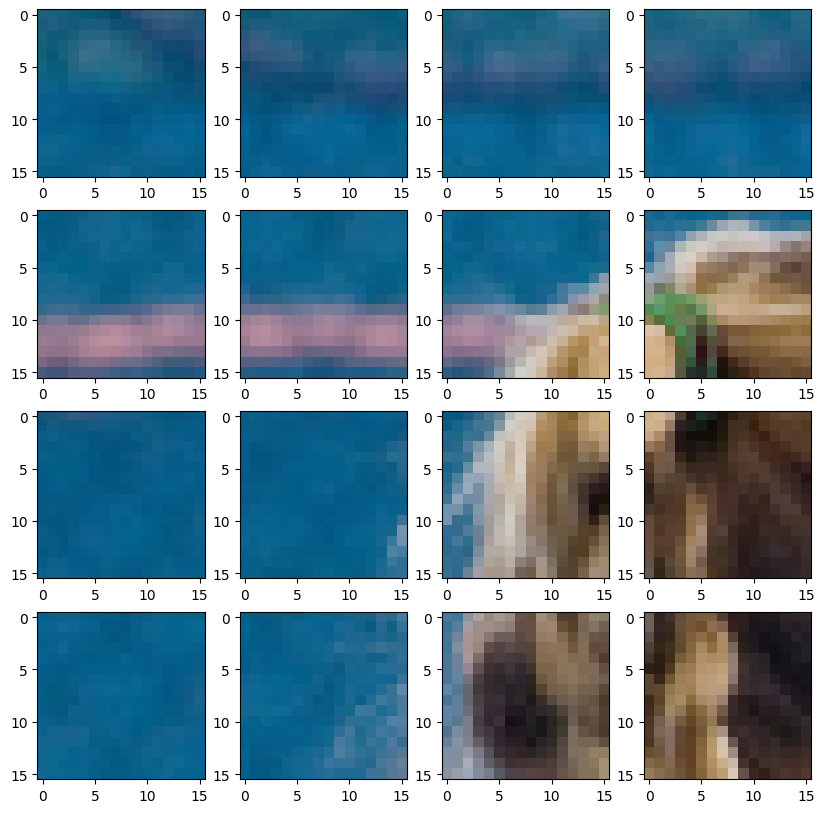

In [29]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for row in range(4):
    for col in range(4):
        axes[row][col].imshow(patches[0][row * 16 + col])

In [30]:
patches = patches.view(1, 256, -1)

In [31]:
img = mg.patches_to_image(patches, (3, 256, 256))

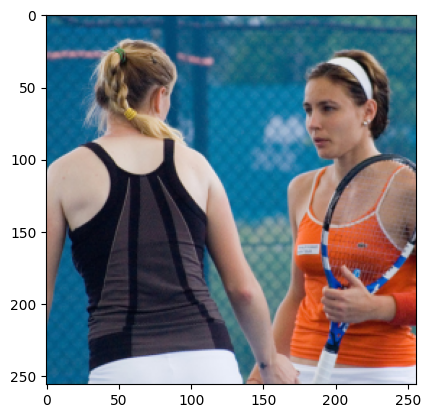

In [32]:
plt.imshow(img[0].permute(1, 2, 0))

In [2]:
import torch
from transformers import GPT2Model

# Initialize model
model = GPT2Model.from_pretrained('gpt2')

# Number of model parameters
num_params = sum(p.numel() for p in model.parameters())

# Data type size (float32 = 4 bytes)
dtype_size = 4

# Calculate memory for model parameters
param_memory = num_params * dtype_size

# Batch size and sequence length
batch_size = 8
seq_length = 1024

# Hidden size from GPT-2 config
hidden_size = model.config.hidden_size
num_layers = model.config.n_layer

# Calculate memory for activations
activation_memory = batch_size * seq_length * hidden_size * num_layers * dtype_size

# Calculate memory for gradients
gradient_memory = num_params * dtype_size

# Optimizer states (Adam)
optimizer_memory = num_params * dtype_size * 2

# Total memory estimate
total_memory = param_memory + activation_memory + gradient_memory + optimizer_memory

# Convert to MB
total_memory_mb = total_memory / (1024 ** 2)

print(f"Estimated Total Memory: {total_memory_mb:.2f} MB")

Estimated Total Memory: 2186.80 MB


In [3]:
f"{param_memory / 1e6:.2f}"

'497.76'

In [5]:
import torchtext
import portalocker
import datasets

In [12]:
train, valid, test = torchtext.datasets.PennTreebank('./', 'text')
it = iter(train)
ex = next(it)

TypeError: PennTreebank() got multiple values for argument 'root'

In [14]:
owt = datasets.load_dataset('Skylion007/openwebtext', trust_remote_code=False)

ValueError: Loading Skylion007/openwebtext requires you to execute the dataset script in that repo on your local machine. Make sure you have read the code there to avoid malicious use, then set the option `trust_remote_code=True` to remove this error.

In [7]:
ds = datasets.Dataset.from_generator(train)

Generating train split: 0 examples [00:00, ? examples/s]

DatasetGenerationError: An error occurred while generating the dataset